In [7]:
# ] instantiate # remove comments to install packages

## Setup model and install packages

In [78]:
using DifferentiableStateSpaceModels, DifferenceEquations, LinearAlgebra, Zygote, Distributions, Plots, DiffEqBase, Symbolics

# Model equations and steady states

In [97]:
∞ = Inf
@variables α, β, ρ, δ, σ, Ω_1
@variables t::Integer, k(..), z(..), c(..), q(..)

x = [k, z]
y = [c, q]
p = [α, β, ρ, δ, σ, Ω_1]

H = [1 / c(t) - (β / c(t + 1)) * (α * exp(z(t + 1)) * k(t + 1)^(α - 1) + (1 - δ)),
     c(t) + k(t + 1) - (1 - δ) * k(t) - q(t),
     q(t) - exp(z(t)) * k(t)^α,
     z(t + 1) - ρ * z(t)]

steady_states = [k(∞) ~ (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 z(∞) ~ 0,
                 c(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1)) -
                        δ * (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 q(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1))]

Γ = reshape([σ], 1, 1)
η = reshape([0; -1], length(x), 1) # η is n_x * n_ϵ matrix

Q = zeros(2, length(x) + length(y))
Q[1, 1] = 1.0
Q[2, 3] = 1.0

Ω = [Ω_1, Ω_1]

# Generates the files and includes if required.  If the model is already created, then just loads
model_rbc = @make_and_include_perturbation_model("rbc_notebook_example", H, (; t, y, x, p, steady_states, Γ, Ω, η, Q)) # Convenience macro.  Saves as ".function_cache/rbc_notebook_example.jl"

# After generation could just include directly with the following code
# isdefined(Main, :rbc_notebook_example) || include(joinpath(pkgdir(DifferentiableStateSpaceModels),
#                                              "test/generated_models/rbc_notebook_example.jl"))


# Alternatively, this is the same as a prebuilt example
# model_rbc = @include_example_module(DifferentiableStateSpaceModels.Examples.rbc_observables)  # or use prebuilt model

Building model up to order 2
Substituting and simplifying
Building model functions
Saved rbc_notebook_example to C:\Users\jesse\.julia\packages\DifferentiableStateSpaceModels\rQrsQ\.function_cache\rbc_notebook_example.jl


Perturbation Model: n_y = 2, n_x = 2, n_p = 6, n_ϵ = 1, n_z = 2
 y = [:c, :q] 
 x = [:k, :z] 
 p = [:α, :β, :ρ, :δ, :σ, :Ω_1]

In [98]:
model_rbc.mod.m.H_latex # model_H_latex(model_rbc)

L"$\begin{equation}
\left[
\begin{array}{c}
\frac{ - \beta \left( 1 - \delta + \left( k\left( 1 + t \right) \right)^{-1 + \alpha} \alpha e^{z\left( 1 + t \right)} \right)}{c\left( 1 + t \right)} + \frac{1}{c\left( t \right)} \\
 - q\left( t \right) - \left( 1 - \delta \right) k\left( t \right) + c\left( t \right) + k\left( 1 + t \right) \\
 - \left( k\left( t \right) \right)^{\alpha} e^{z\left( t \right)} + q\left( t \right) \\
 - \rho z\left( t \right) + z\left( 1 + t \right) \\
\end{array}
\right]
\end{equation}
$"

In [99]:
model_rbc.mod.m.steady_states_latex # model_steady_states_latex(model_rbc)

L"$\begin{align}
k\left( \infty \right) =& \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{1}{-1 + \alpha}} \\
z\left( \infty \right) =& 0 \\
c\left( \infty \right) =& \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{\alpha}{-1 + \alpha}} - \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{1}{-1 + \alpha}} \delta \\
q\left( \infty \right) =& \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{\alpha}{-1 + \alpha}}
\end{align}
$"

# Simulate data using DifferenceEquations

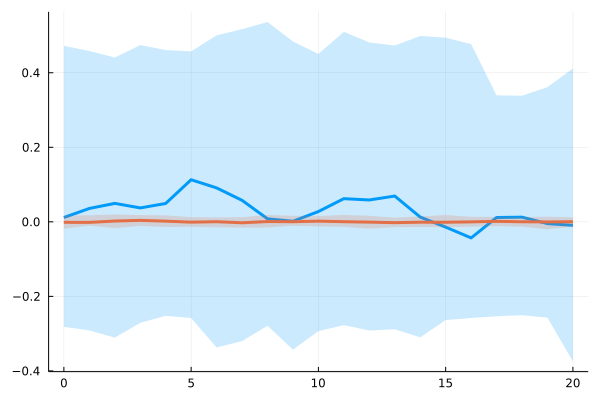

In [100]:
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
sol = generate_perturbation(model_rbc, p_d, p_f) # Solution to the first-order RBC
sol_2 = generate_perturbation(model_rbc, p_d, p_f, Val(2)) # Solution to the second-order RBC

# Simulate multiple trajectories with T observations
T = 20
trajectories = 40

# draw from ergodic for each simulation
x_iv = MvNormal(sol.x_ergodic_var) # draw initial conditions from the ergodic distribution
problem = LinearStateSpaceProblem(sol, x_iv, (0, T))

# Solve multiple trajectories and plot an ensemble
ensemble_results = solve(EnsembleProblem(problem), DirectIteration(), EnsembleThreads();
                 trajectories)
plot(EnsembleSummary(ensemble_results))

## Calculate Sequence of Observables

In [101]:
# Simulate multiple trajectories with T observations
T = 20
trajectories = 40

# draw from ergodic for each simulation
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
sol = generate_perturbation(model_rbc, p_d, p_f) # Solution to the first-order RBC

x_iv = MvNormal(sol.x_ergodic_var) # draw initial conditions from the ergodic distribution
problem = LinearStateSpaceProblem(sol, x_iv, (0, T))
sim = solve(problem, DirectIteration())
ϵ = sim.W # store the underlying noise in the simulation
z = sim.z;# simulated observables

## Bayesian Estimation with Turing 

In [102]:
## Estimation example: first-order, marginal likelihood approach
using Turing
using Turing: @addlogprob!
Turing.setadbackend(:zygote);

# Turing model definition
@model function rbc_kalman(z, m, p_f, cache)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    p_d = (; α, β)
    T = size(z, 2)
    sol = generate_perturbation(m, p_d, p_f, Val(1); cache)
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    problem = LinearStateSpaceProblem(sol, zeros(2), (0, T),observables = z)
    @addlogprob! solve(problem, KalmanFilter()).logpdf
end
cache = SolverCache(model_rbc, Val(1),  [:α, :β])
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
turing_model = rbc_kalman(z, model_rbc, p_f, cache)

n_samples = 1000
n_adapts = 100
δ = 0.65
alg = NUTS(n_adapts,δ)
chain = sample(turing_model, alg, n_samples; progress = true)

LoadError: DimensionMismatch("array could not be broadcast to match destination")